In [2]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
import Levenshtein

import sys
sys.path.append('..')
from lib import *

from pyrepseq import *
import random

plt.style.use('../peptidome.mplstyle')

/home/andreas/mambaforge/envs/peptidome/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
k = 10
selfset = set(count_kmers_proteome(human, k, clean=True))

In [4]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

248879


In [5]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

69747


In [6]:
# only epitopes of length k
mask = df_t['Epitope', 'Description'].apply(len)==k
df_t = df_t[mask]
print(df_t.shape[0])

17017


In [7]:
# no host epitopes
host = 'Homo sapiens'
# can also set na=True to exclude epitopes of unknown provenance
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

15260


In [8]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

14287


In [9]:
# restrict to ELISPOT assay
mask = df_t['Assay', 'Method/Technique'] == 'ELISPOT'
df_t = df_t[mask]
print(df_t.shape[0])

10096


# Keep most frequent qualitative measure

In [10]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = df_t[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()
len(d)

3331

In [11]:
epitope_counts = df_t.groupby(('Epitope', 'Description')).agg('count')['Reference', 'Assay IRI']
(epitope_counts>1).sum()

2099

In [12]:
positive_fraction = df_t.groupby(('Epitope', 'Description')).agg(np.mean)['Assay', 'Positive']
len(positive_fraction[(positive_fraction>0.0) & (positive_fraction<1.0)])

138

(1.0, 3512.3465955068095)

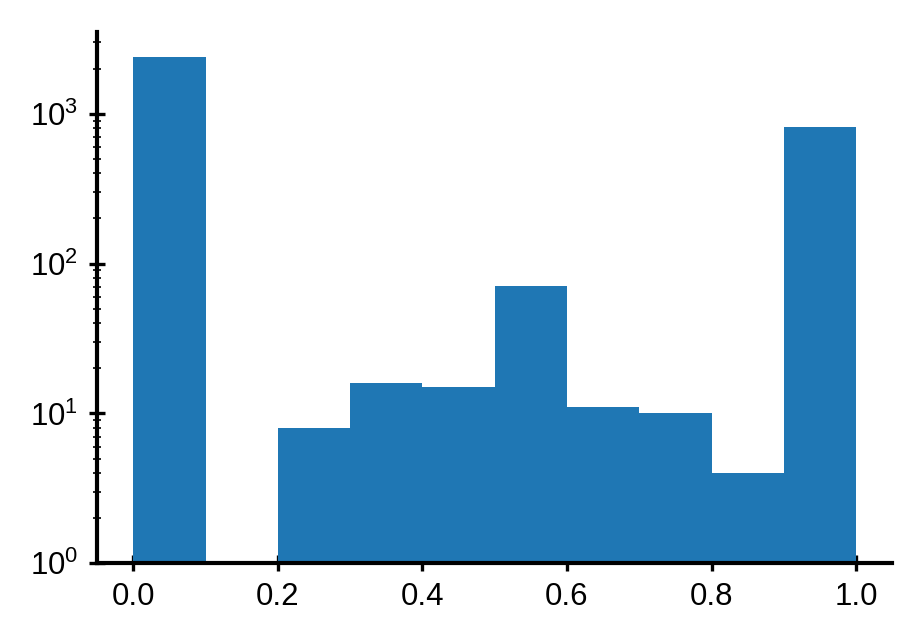

In [13]:
plt.hist(positive_fraction)
plt.yscale('log')
plt.ylim(1e0)

# Keep only unambiguous

In [14]:
d_mean = df_t[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(np.mean)
d = d_mean[d_mean['Assay', 'Positive'].isin([0.0, 1.0])]
d = d.reset_index()
len(d)

3193

In [19]:
d['nndist'] = d['Epitope', 'Description'].apply(lambda x: nndist_hamming(x, selfset, maxdist=4))

In [20]:
d['nndist_max'] = np.where(d['nndist']>4, 4, d['nndist'])
dagg = d.groupby('nndist_max').agg(['mean', 'count'])['Assay', 'Positive']
ps = np.asarray(list(dagg['mean']))
ns = np.asarray(dagg['count'])
ps, ns

(array([0.        , 0.23809524, 0.26106195, 0.26666667, 0.22535211]),
 array([  20,   21,  226, 2145,  781]))

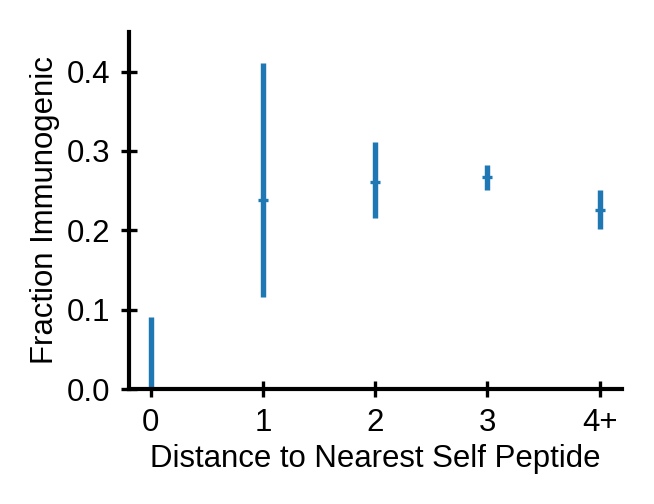

In [25]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
ax.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0.0, 0.45)
ax.set_xlabel('Distance to Nearest Self Peptide')
ax.set_ylabel('Fraction Immunogenic')
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels([0, 1, 2, 3, '4+'])
fig.tight_layout()
fig.savefig(figuredir+'iedbposvsdist_k10.svg')

In [22]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((0, 1), 0.13106798968500855),
 ((0, 2), 0.07623739314742684),
 ((0, 3), 0.06874121168371838),
 ((0, 4), 0.1228017149396542),
 ((1, 2), 0.9971126955261476),
 ((1, 3), 0.9971126955261476),
 ((1, 4), 0.9971126955261476),
 ((2, 3), 0.9971126955261476),
 ((2, 4), 0.7835611289247056),
 ((3, 4), 0.13264458355791986)]